In [89]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns
import gc

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.regularizers import l1, l2

from keras.models import Model, Sequential, load_model
from keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, SpatialDropout1D, \
                          UpSampling1D, LSTM, RepeatVector, TimeDistributed, GRU, Bidirectional, concatenate, \
                          Reshape, Dropout, BatchNormalization, Embedding, GlobalAveragePooling2D, Masking

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#from utils import get_model, find_closest, get_sequences, create_train_valid,  generate_output, guess_human

import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
pd.set_option('max_colwidth', -1)

In [90]:
data_original = pd.read_csv('seq_rec.csv', sep = ';')
print(data_original.shape)
data_original.head()

(48070, 12)


,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime
0,Lince™,G9UUP2GY,70.0,CRL EU,8330785.0,Hogrider,SameClan,"skeletons,ice-spirit,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",142.0,51.0,91.0,2019-05-11
1,xPedro15,VLURPP9,70.0,CRL EU,8526335.0,Hogrider,Friendly,"ice-spirit,skeletons,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",14.0,6.0,8.0,2019-05-11
2,Lince™,G9UUP2GY,70.0,CRL EU,8526733.0,MinerControl,SameClan,"skeletons,ice-spirit,the-log,electro-wizard,valkyrie,inferno-tower,miner,poison",70.0,26.0,44.0,2019-05-11
3,AQ Olaf,2PQUYV9G,51.0,Black EF / PG / CTP - Arena Quesito,8528839.0,Hogrider,Challenge,"skeletons,ice-spirit,the-log,ice-golem,cannon,fireball,musketeer,hog-rider",27.0,12.0,15.0,2019-05-11
4,xPedro15,VLURPP9,70.0,CRL EU,8529261.0,Giant,SameClan,"zap,the-log,mega-minion,poison,dark-prince,electro-wizard,prince,giant",7.0,1.0,6.0,2019-05-11


### Data cleaning

In [91]:
data_original['date'] = pd.to_datetime(data_original['BattleTime']).dt.date

In [92]:
data_original.dropna(axis = 0, inplace = True)

In [93]:
ints = ['TeamId', 'DeckId', 'Games', 'Losses', 'Wins']
for col in ints:
    data_original[col] = data_original[col].astype(int)
data_original.head()

,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date
0,Lince™,G9UUP2GY,70,CRL EU,8330785,Hogrider,SameClan,"skeletons,ice-spirit,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",142,51,91,2019-05-11,2019-05-11
1,xPedro15,VLURPP9,70,CRL EU,8526335,Hogrider,Friendly,"ice-spirit,skeletons,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",14,6,8,2019-05-11,2019-05-11
2,Lince™,G9UUP2GY,70,CRL EU,8526733,MinerControl,SameClan,"skeletons,ice-spirit,the-log,electro-wizard,valkyrie,inferno-tower,miner,poison",70,26,44,2019-05-11,2019-05-11
3,AQ Olaf,2PQUYV9G,51,Black EF / PG / CTP - Arena Quesito,8528839,Hogrider,Challenge,"skeletons,ice-spirit,the-log,ice-golem,cannon,fireball,musketeer,hog-rider",27,12,15,2019-05-11,2019-05-11
4,xPedro15,VLURPP9,70,CRL EU,8529261,Giant,SameClan,"zap,the-log,mega-minion,poison,dark-prince,electro-wizard,prince,giant",7,1,6,2019-05-11,2019-05-11


### Clean Cards Ids

In [94]:
#print(', '.join(sorted(data_original['CardKeysRaw'][0].split(','))))

In [95]:
data_original['CardKeysRawSorted'] = data_original['CardKeysRaw'].apply(lambda x: ', '.join(sorted(x.split(','))))
data_original.head()

,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date,CardKeysRawSorted
0,Lince™,G9UUP2GY,70,CRL EU,8330785,Hogrider,SameClan,"skeletons,ice-spirit,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",142,51,91,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log"
1,xPedro15,VLURPP9,70,CRL EU,8526335,Hogrider,Friendly,"ice-spirit,skeletons,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",14,6,8,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log"
2,Lince™,G9UUP2GY,70,CRL EU,8526733,MinerControl,SameClan,"skeletons,ice-spirit,the-log,electro-wizard,valkyrie,inferno-tower,miner,poison",70,26,44,2019-05-11,2019-05-11,"electro-wizard, ice-spirit, inferno-tower, miner, poison, skeletons, the-log, valkyrie"
3,AQ Olaf,2PQUYV9G,51,Black EF / PG / CTP - Arena Quesito,8528839,Hogrider,Challenge,"skeletons,ice-spirit,the-log,ice-golem,cannon,fireball,musketeer,hog-rider",27,12,15,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log"
4,xPedro15,VLURPP9,70,CRL EU,8529261,Giant,SameClan,"zap,the-log,mega-minion,poison,dark-prince,electro-wizard,prince,giant",7,1,6,2019-05-11,2019-05-11,"dark-prince, electro-wizard, giant, mega-minion, poison, prince, the-log, zap"


In [96]:
Decks = pd.DataFrame({'deck':data_original['CardKeysRawSorted']})
print(Decks.shape)
Decks.head()
Decks = Decks.groupby('deck').size().to_frame('times').reset_index().sort_values(by = 'times',ascending = False)
print(Decks.shape)
Decks['deck_id_int'] = [id for id in range(Decks.shape[0])]
Decks.head()

(48047, 1)
(12869, 2)


,deck,times,deck_id_int
3144,"balloon, barbarian-barrel, bats, giant-snowball, ice-golem, inferno-tower, miner, rascals",341,0
1398,"baby-dragon, barbarian-barrel, electro-wizard, furnace, guards, lightning, mega-minion, royal-giant",339,1
790,"baby-dragon, bandit, barbarian-barrel, electro-wizard, giant-snowball, pekka, poison, ram-rider",320,2
4923,"bandit, battle-ram, fireball, giant-snowball, ice-golem, minions, musketeer, prince",315,3
10028,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",294,4


#### Delete redundant Decks 

In [97]:
data_original = pd.merge(data_original, Decks, how = 'inner', left_on = 'CardKeysRawSorted', right_on = 'deck')
data_original.head(3)

,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date,CardKeysRawSorted,deck,times,deck_id_int
0,Lince™,G9UUP2GY,70,CRL EU,8330785,Hogrider,SameClan,"skeletons,ice-spirit,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",142,51,91,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",294,4
1,xPedro15,VLURPP9,70,CRL EU,8526335,Hogrider,Friendly,"ice-spirit,skeletons,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",14,6,8,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",294,4
2,AQ Olaf,2PQUYV9G,51,Black EF / PG / CTP - Arena Quesito,8528839,Hogrider,Challenge,"skeletons,ice-spirit,the-log,ice-golem,cannon,fireball,musketeer,hog-rider",27,12,15,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",294,4


In [100]:
indexNames = data_original[(data_original.Games == 1) & (data_original.times == 1)].index
data_original.drop(axis = 0, index = indexNames, inplace = True)
data_original.drop(axis = 1, inplace = True, columns=['deck_id_int', 'times', 'deck'])
data_original = data_original.reset_index(drop = True)
data_original.shape

#We need to re'generate the decks ids

Decks = pd.DataFrame({'deck':data_original['CardKeysRawSorted']})
print(Decks.shape)
Decks.head()
Decks = Decks.groupby('deck').size().to_frame('times').reset_index().sort_values(by = 'times',ascending = False)
print(Decks.shape)
Decks['deck_id_int'] = [id for id in range(Decks.shape[0])]
Decks.head()

data_original = pd.merge(data_original, Decks, how = 'inner', left_on = 'CardKeysRawSorted', right_on = 'deck')
data_original.head(3)

(41642, 1)
(6464, 2)


,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date,CardKeysRawSorted,deck,times,deck_id_int
0,Lince™,G9UUP2GY,70,CRL EU,8330785,Hogrider,SameClan,"skeletons,ice-spirit,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",142,51,91,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",294,4
1,xPedro15,VLURPP9,70,CRL EU,8526335,Hogrider,Friendly,"ice-spirit,skeletons,ice-golem,the-log,cannon,musketeer,fireball,hog-rider",14,6,8,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",294,4
2,AQ Olaf,2PQUYV9G,51,Black EF / PG / CTP - Arena Quesito,8528839,Hogrider,Challenge,"skeletons,ice-spirit,the-log,ice-golem,cannon,fireball,musketeer,hog-rider",27,12,15,2019-05-11,2019-05-11,"cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",294,4


### Data preparation

In [101]:
player_unique = data_original.Tag.unique()
teams_unique = data_original.TeamId.unique()
deck_unique = data_original.deck_id_int.unique()
archetype_unique = data_original.Archetype.unique()
usage_unique = data_original.Usage.unique()

print (f'We have {len(player_unique)} unique Players {len(teams_unique)} unique Teams'+\
       f' {len(deck_unique) } unique Decks {len(archetype_unique)} unique Archetypes and {len(usage_unique)} types of usages')

We have 430 unique Players 47 unique Teams 6464 unique Decks 23 unique Archetypes and 4 types of usages


In [102]:
players_map = {i:val for i,val in enumerate(player_unique)}
players_map_inv = {val:i for i,val in enumerate(player_unique)}

teams_map = {i:val for i,val in enumerate(teams_unique)}
teams_map_inv = {val:i for i,val in enumerate(teams_unique)}

decks_map = {i:val for i,val in enumerate(deck_unique)}
decks_map_inv = {val:i for i,val in enumerate(deck_unique)}

archetypes_map = {i:val for i,val in enumerate(archetype_unique)}
archetypes_map_inv = {val:i for i,val in enumerate(archetype_unique)}

usages_map = {i:val for i,val in enumerate(usage_unique)}
usages_map_inv = {val:i for i,val in enumerate(usage_unique)}

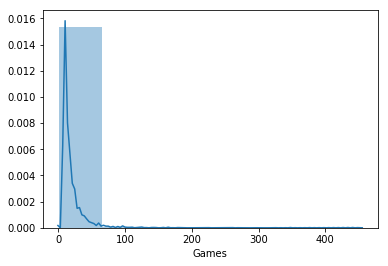

In [103]:
sns.distplot(data_original['Games'], bins = 7)

## Mapping Cards

In [104]:
data_original['CardKeysRaw'] = data_original['CardKeysRaw'].str.replace('-', '')
data_original['CardKeysRawSorted'] = data_original['CardKeysRawSorted'].str.replace('-', '')

In [105]:
MAX_NB_CARDS = 200 #decided by cumsum wordcount plot (Script 01)
MAX_SEQUENCE_LENGTH = 8 #decided by max words in a product (Script 00)
EMBEDDING_DIM = 8 #Same dim as our W2V embedding

all_cards = data_original['CardKeysRaw']
all_cards = all_cards.drop_duplicates (keep = False)

tokenizer = Tokenizer(num_words=MAX_NB_CARDS)
tokenizer.fit_on_texts(all_cards)

data_sequences = tokenizer.texts_to_sequences(data_original['CardKeysRaw'])
#data_matrix = tokenizer.
X = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
index_word = dict(map(reversed, tokenizer.word_index.items()))
y = np.array(data_original['deck_id_int']) 

print('Found %s unique tokens.' % len(word_index))
print (f'There are {len(X)} sequences')
#print(word_index)
#print(data_vec[0])
#print(data_original['CardKeysRaw'].loc[0])

Found 92 unique tokens.
There are 41642 sequences


In [106]:
print(X[0:3])
print(y[0:3])

[[21 24 10 13 85 17  5 40]
 [24 21 10 13 85 17  5 40]
 [21 24 13 10 85  5 17 40]]
[4 4 4]


In [107]:
for i, seq in enumerate(X[0:3]):
    print(i)
    my_cards = []
    for idx in seq:
        my_cards.append(index_word[idx])
    print('Features: ' + '-'.join(my_cards))
    print('Label: ' + str(y[i+4]) + '\n')    

0
Features: skeletons-icespirit-icegolem-thelog-cannon-musketeer-fireball-hogrider
Label: 4

1
Features: icespirit-skeletons-icegolem-thelog-cannon-musketeer-fireball-hogrider
Label: 4

2
Features: skeletons-icespirit-thelog-icegolem-cannon-fireball-musketeer-hogrider
Label: 4



In [108]:
data_original['Winrate'] = data_original.Wins / data_original.Games

In [109]:
def split_train_valid(x, y, rate):
    idx = int(x.shape[0] * rate)
    return x[idx:], y[idx:], x[:idx], y[:idx]
              
X_train, y_train, X_valid, y_valid = split_train_valid(X, y, rate = 0.1)

In [110]:
print(X.shape)
print(X_train.shape)
print(X_valid.shape)

(41642, 8)
(37478, 8)
(4164, 8)


## Model architecture

### Output

In [146]:
len(word_index)+1

93

In [148]:
y_train = np.zeros((y_train.shape[0], len(word_index)+1), dtype=np.int8)

# One hot encoding of labels
for val in (X):
    y_train[example_index, word_index] = 1

IndexError: index 21 is out of bounds for axis 1 with size 9

In [142]:
CAT_DECKS = len(deck_unique)
decks_encoded_train = to_categorical(y_train, num_classes = CAT_DECKS)
decks_encoded_valid = to_categorical(y_train, num_classes = CAT_DECKS)
#print(decks_encoded_train)
print(decks_encoded_train.shape)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'dict_keys'

In [115]:
data_original.head(3)

,Player,Tag,TeamId,Team,DeckId,Archetype,Usage,CardKeysRaw,Games,Losses,Wins,BattleTime,date,CardKeysRawSorted,deck,times,deck_id_int,Winrate
0,Lince™,G9UUP2GY,70,CRL EU,8330785,Hogrider,SameClan,"skeletons,icespirit,icegolem,thelog,cannon,musketeer,fireball,hogrider",142,51,91,2019-05-11,2019-05-11,"cannon, fireball, hogrider, icegolem, icespirit, musketeer, skeletons, thelog","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",294,4,0.640845
1,xPedro15,VLURPP9,70,CRL EU,8526335,Hogrider,Friendly,"icespirit,skeletons,icegolem,thelog,cannon,musketeer,fireball,hogrider",14,6,8,2019-05-11,2019-05-11,"cannon, fireball, hogrider, icegolem, icespirit, musketeer, skeletons, thelog","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",294,4,0.571429
2,AQ Olaf,2PQUYV9G,51,Black EF / PG / CTP - Arena Quesito,8528839,Hogrider,Challenge,"skeletons,icespirit,thelog,icegolem,cannon,fireball,musketeer,hogrider",27,12,15,2019-05-11,2019-05-11,"cannon, fireball, hogrider, icegolem, icespirit, musketeer, skeletons, thelog","cannon, fireball, hog-rider, ice-golem, ice-spirit, musketeer, skeletons, the-log",294,4,0.555556


In [129]:
def get_model_Seq():
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=30,
                    weights=None,
                    trainable=True, name = 'Cards'))
    
    #model.add(Masking()) #Para los zeros

    # Recurrent layer
    #model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))
    model.add(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.1))

    # Fully connected layer
    model.add(Dense(64, activation = 'relu'))

    # Dropout for regularization
    model.add(Dropout(0.5))
    
    model.add(Dense(32, activation = 'relu'))
    
    model.add(Dropout(0.4))

    # Output layer
    model.add(Dense(CAT_DECKS, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    return model

In [130]:
data_original.columns

Index(['Player', 'Tag', 'TeamId', 'Team', 'DeckId', 'Archetype', 'Usage',
       'CardKeysRaw', 'Games', 'Losses', 'Wins', 'BattleTime', 'date',
       'CardKeysRawSorted', 'deck', 'times', 'deck_id_int', 'Winrate'],
      dtype='object')

In [132]:
model = get_model_Seq()

# Sequence

#class_weights = {0: 1.0, 1: 2.0}

history = model.fit(X_train,
                    decks_encoded_train,
                    validation_data = (X_valid, decks_encoded_valid), 
                    epochs = 40, class_weight = None,
                    batch_size = 128, shuffle = False, verbose = 1)

# Classifier
#history = model.fit([data_feed['Tag'], data_feed['TeamId'], data_feed['Archetype'], data_feed['Usage'],
#                    data_feed['Games'], data_feed['Wins'], data_feed['Losses'], data_feed['deck_id_int'], data_vec],
#                    [decks_encoded, data_feed['Winrate']], 
#                    epochs = 4, validation_split = 0.1,
#                    batch_size = 64, 
#                    shuffle = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Cards (Embedding)            (None, None, 30)          2790      
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                24320     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 6464)              213312    
Total para

KeyboardInterrupt: 

In [ ]:
pred = model.predict(X_valid, verbose = 1)

In [ ]:
print(pred.shape)
print(pred[0].shape)

In [ ]:
pred[0].argsort()[-5:][::-1]

In [ ]:
y_valid[103]